# Data Preparation

## Load Data

In [661]:
import pandas as pd
import numpy as np

In [662]:
def read_data(fname: str):
  file = './datasets/'+fname
  data = pd.read_csv(file,  sep = ';')

  print('Data shape raw: '+ str(data.shape))

  duplicates = data.duplicated(keep="first", subset=["id"])
  print('Number of duplicate id: '+ str(duplicates.sum()))

  data = data.drop_duplicates(keep="first", subset=["id"])
  print('Data shape after dropping: '+ str(data.shape))

  data = data.set_index('id')
  print('Data shape final: '+ str(data.shape))

  return data

In [663]:
data = read_data(fname='final_task.csv')

Data shape raw: (44555, 12)
Number of duplicate id: 3571
Data shape after dropping: (40984, 12)
Data shape final: (40984, 11)


In [730]:
data.head()

,match_percentage,dob,gender,experience,gpa,marital_status_id,educ_id,fresh_graduate,expected_salary,registered_from,is_hired,dob_converted
id,,,,,,,,,,,,
2506320329821,0.0,01/12/1991,Male,0.0,0.0,3.0,0.0,1.0,5000000.0,jobseeker.app,0,1991-12-01
2506320329816,0.0,01/12/1991,Male,0.0,0.0,3.0,0.0,1.0,5000000.0,jobseeker.app,0,1991-12-01
2506452329816,25.0,16/11/1994,Female,1.0,0.0,0.0,18.0,0.0,0.0,jobseeker.app,0,1994-11-16
2506430329869,67.0,29/11/1995,Female,1.0,0.0,1.0,22.0,0.0,0.0,jobseeker.app,0,1995-11-29
2506653329842,13.0,27/10/1999,Female,2.0,0.0,1.0,22.0,0.0,4500000.0,jobseeker.app,0,1999-10-27


## Perform EDA

In [664]:
from datetime import datetime

def prepare_dob(data: pd.DataFrame):
    data['dob_converted'] = pd.to_datetime(data['dob'], format='%d/%m/%Y', errors='coerce')
    dropped = data.drop(data[data['dob_converted'].isna()].index)

    current_date = pd.to_datetime(datetime.now().date())
    dropped['age'] = ((current_date - dropped['dob_converted']).dt.days / 365).astype(int)

    dropped = dropped.drop(columns=['dob', 'dob_converted'])
    return dropped


In [665]:

def drop_anomalies(data: pd.DataFrame):
    dropped_ids = []
    
    dropped_ids += data.index[data['experience'] < 0].tolist()
    print(len(dropped_ids))
    dropped_ids += data.index[data['experience'] > 30].tolist()
    print(len(dropped_ids))
    dropped_ids += data.index[data['age'] < 18].tolist()
    print(len(dropped_ids))
    dropped_ids += data.index[data['expected_salary'] > 50_000_000].tolist()
    print(len(dropped_ids))
    
    dropped_ids += data.index[data['gpa'] > 99].tolist()
    print(len(dropped_ids))
    # assume the candidate graduate from SMA or S1 so nothing value from 4 < gpa < 70
    dropped_ids += data.index[(data['gpa'] > 4) & (data['gpa'] < 70)].tolist()
    print(len(dropped_ids))

    dropped_anomalies = data.drop(dropped_ids)
    return dropped_anomalies


In [666]:
def update_educ_id(data: pd.DataFrame):
    if data['educ_id'] < 10 or pd.isna(data['educ_id']):
        if data['gpa'] <= 4:
            return 31
        elif data['gpa'] > 4:
            return 12
    return data['educ_id']

# change gpa > 70 to 4 format
def reformat_gpa(data: pd.DataFrame):
    data.loc[data['gpa'] > 4, 'gpa'] /= 25
    data['educ_id'] = data.apply(update_educ_id, axis=1)
    
    return data

In [667]:
def fill_empty_registered(data: pd.DataFrame):
    data.loc[data['registered_from'].isna(), 'registered_from'] = 'unknown'

    return data

In [668]:
def fill_non_string_expected(data: pd.DataFrame):
    data['expected_salary'] = pd.to_numeric(data['expected_salary'], errors='coerce')
    
    return data

In [669]:
def fill_zero_marital(data: pd.DataFrame):
    data.loc[data['marital_status_id'] == 0, 'marital_status_id'] = 1
    
    return data

In [670]:
def preprocess_data(data: pd.DataFrame):
    print('Data before preprocessing: ', str(data.shape))

    filled_expected = fill_non_string_expected(data=data)
    prepared_dob = prepare_dob(data=filled_expected)
    dropped_anomalies = drop_anomalies(data=prepared_dob)
    reformated_gpa = reformat_gpa(data=dropped_anomalies)
    filled_registered = fill_empty_registered(data=reformated_gpa)
    filled_zero_marital = fill_zero_marital(data=filled_registered)

    print('Data after preprocessing: ', str(filled_zero_marital.shape))
    return filled_registered

In [671]:
data.describe()

,match_percentage,experience,gpa,marital_status_id,educ_id,fresh_graduate,is_hired
count,40853.000000,40847.000000,40847.000000,40847.000000,40847.000000,40848.000000,40984.000000
mean,73.343965,1.464465,2.087440,1.360932,1.768600,0.612099,0.013273
std,27.666717,3.513909,111.284048,0.839983,6.507828,0.487278,0.114445
min,0.000000,-75.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,83.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,100.000000,2.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,100.000000,169.000000,9999.000000,7.000000,71.000000,1.000000,1.000000


In [672]:
100 * (data.isna().sum(0) / len(data))

match_percentage     0.319637
dob                  0.331837
gender               0.495315
experience           0.334277
gpa                  0.334277
marital_status_id    0.334277
educ_id              0.334277
fresh_graduate       0.331837
expected_salary      6.846574
registered_from      2.574175
is_hired             0.000000
dtype: float64

In [673]:
cleaned_data = preprocess_data(data=data)
100 * (cleaned_data.isna().sum(0) / len(cleaned_data))

Data before preprocessing:  (40984, 11)
25
82
100
164
215
429
Data after preprocessing:  (40308, 11)


match_percentage     0.000000
gender               0.000000
experience           0.000000
gpa                  0.000000
marital_status_id    0.000000
educ_id              0.000000
fresh_graduate       0.000000
expected_salary      6.606629
registered_from      0.000000
is_hired             0.000000
age                  0.000000
dtype: float64

In [674]:
cleaned_data.describe()

,match_percentage,experience,gpa,marital_status_id,educ_id,fresh_graduate,expected_salary,is_hired,age
count,40308.000000,40308.000000,40308.000000,40308.000000,40308.000000,40308.000000,3.764500e+04,40308.000000,40308.000000
mean,73.713953,1.408678,0.258458,1.366701,30.512628,0.613501,5.203101e+06,0.013446,25.717500
std,27.376497,2.274405,0.901769,0.827924,2.661866,0.486953,3.124634e+06,0.115178,3.797744
min,0.000000,0.000000,0.000000,1.000000,10.000000,0.000000,0.000000e+00,0.000000,18.000000
25%,50.000000,0.000000,0.000000,1.000000,31.000000,0.000000,4.000000e+06,0.000000,23.000000
50%,83.000000,1.000000,0.000000,1.000000,31.000000,1.000000,5.000000e+06,0.000000,25.000000
75%,100.000000,2.000000,0.000000,1.000000,31.000000,1.000000,5.500000e+06,0.000000,27.000000
max,100.000000,30.000000,3.970000,7.000000,71.000000,1.000000,5.000000e+07,1.000000,62.000000


** NUMERICAL IMPUTATION **

In [676]:
from sklearn.impute import SimpleImputer
def num_imputer_fit(data: pd.DataFrame):
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    return imputer.fit(data)

def num_imputer_transform(data: pd.DataFrame, imputer = SimpleImputer):
    imputed_data = imputer.transform(data)
    return pd.DataFrame(imputed_data, columns=data.columns.astype(str))

In [677]:
data_num_cols = ['age', 'match_percentage', 'experience', 'gpa', 'expected_salary']
data_num = cleaned_data[data_num_cols]

# Get the numerical imputer
num_imputer = num_imputer_fit(data_num)

# Transform the data
data_num_imputed = num_imputer_transform(data_num, num_imputer)

In [678]:
data_num_imputed.isna().sum(0)

age                 0
match_percentage    0
experience          0
gpa                 0
expected_salary     0
dtype: int64

In [679]:
data_num_imputed.head()

,age,match_percentage,experience,gpa,expected_salary
0,32.0,0.0,0.0,0.0,5000000.0
1,32.0,0.0,0.0,0.0,5000000.0
2,29.0,25.0,1.0,0.0,0.0
3,28.0,67.0,1.0,0.0,0.0
4,24.0,13.0,2.0,0.0,4500000.0


## Standarization Numerical Data

In [680]:
from sklearn.preprocessing import StandardScaler
def fit_scaler(data: pd.DataFrame):
  scaler = StandardScaler()
  return scaler.fit(data)

def transform_scaler(data: pd.DataFrame, scaler: StandardScaler):
  scaled_data = scaler.transform(data)

  return pd.DataFrame(scaled_data, columns=data.columns.astype(str))


In [681]:
# standarization
def standarization(data):
  scaler = fit_scaler(data)
  standarized_num = transform_scaler(data, scaler)

  return standarized_num

standarized_num = standarization(data_num_imputed)

In [682]:
data_num_imputed.describe().round(4)

,age,match_percentage,experience,gpa,expected_salary
count,40308.0000,40308.0000,40308.0000,40308.0000,4.030800e+04
mean,25.7175,73.7140,1.4087,0.2585,5.189683e+06
std,3.7977,27.3765,2.2744,0.9018,3.020073e+06
min,18.0000,0.0000,0.0000,0.0000,0.000000e+00
25%,23.0000,50.0000,0.0000,0.0000,4.000000e+06
50%,25.0000,83.0000,1.0000,0.0000,5.000000e+06
75%,27.0000,100.0000,2.0000,0.0000,5.500000e+06
max,62.0000,100.0000,30.0000,3.9700,5.000000e+07


In [683]:
standarized_num.describe().round(4)

,age,match_percentage,experience,gpa,expected_salary
count,40308.0000,40308.0000,40308.0000,40308.0000,40308.0000
mean,-0.0000,-0.0000,0.0000,0.0000,0.0000
std,1.0000,1.0000,1.0000,1.0000,1.0000
min,-2.0322,-2.6926,-0.6194,-0.2866,-1.7184
25%,-0.7156,-0.8662,-0.6194,-0.2866,-0.3939
50%,-0.1889,0.3392,-0.1797,-0.2866,-0.0628
75%,0.3377,0.9602,0.2600,-0.2866,0.1028
max,9.5538,0.9602,12.5711,4.1159,14.8377


## Encode Categorical Data

In [684]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder

In [685]:
cleaned_data['registered_from'].unique()

array(['jobseeker.app', 'karirsite', 'karirpad', 'unknown',
       'jobseeker.software', 'google', 'jobseeker.app_indeed', 'Linkedin',
       'mobile_site', 'jobseeker.app_partner', 'facebook', 'ATS'],
      dtype=object)

we have several categorical data to encode: 
- Binary: gender, fresh_graduate (no encode)
- Ordinal: educ_id
- OHE: marital_status_id, registered_from

In [686]:
def cat_encoder_transfrom(data: pd.DataFrame):
    ordinal_enc = OrdinalEncoder(categories="auto")
    ohe = OneHotEncoder(sparse_output=False)
    label_enc = LabelEncoder()

    data_registered_ohe = data[['registered_from']]
    data_marital_ohe = data[['marital_status_id']].astype(str)

    data_registered_values = data['registered_from'].unique()
    data_marital_values = data['marital_status_id'].unique().astype(str)

    marital_encoded = pd.DataFrame(ohe.fit_transform(data_marital_ohe), columns=data_marital_values)
    registered_encoded = pd.DataFrame(ohe.fit_transform(data_registered_ohe), columns=data_registered_values)

    data_ordinal_encoded = pd.DataFrame(ordinal_enc.fit_transform(data[['educ_id']]), columns=['educ_id'])

    data_label_encoded = pd.DataFrame(label_enc.fit_transform(data[['gender']]), columns=['gender'])

    # Concatenate encoded dataframes
    data_encoded = pd.concat([marital_encoded, registered_encoded, data_ordinal_encoded, data_label_encoded], axis=1)

    return data_encoded

In [687]:
data_cat = cleaned_data[['gender', 'educ_id', 'registered_from', 'marital_status_id', 'fresh_graduate']]
data_cat_encoded = cat_encoder_transfrom(data_cat)

c:\Users\hafiz\Mine\Learn\pacmann\ai\02_introduction_to_machine_learning\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [688]:
def concat_data(data_num: pd.DataFrame, data_cat: pd.DataFrame):
  print("Numerical data shape: "+str(data_num.shape))
  print("After decode categorical")
  print("Categorical data shape: "+str(data_cat.shape))
  concat_data = pd.concat([data_num, data_cat], axis=1)
  print("Concat data shape: "+str(concat_data.shape))
  
  return concat_data

concat imputed numerical data and encoded categorical data

In [689]:
# Concat the data
data_concat = concat_data(standarized_num, data_cat_encoded)

Numerical data shape: (40308, 5)
After decode categorical
Categorical data shape: (40308, 21)
Concat data shape: (40308, 26)


In [690]:
data_concat.head()

,age,match_percentage,experience,gpa,expected_salary,3.0,1.0,5.0,2.0,7.0,...,jobseeker.software,google,jobseeker.app_indeed,Linkedin,mobile_site,jobseeker.app_partner,facebook,ATS,educ_id,gender
0,1.654292,-2.692633,-0.619369,-0.286615,-0.062808,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,1
1,1.654292,-2.692633,-0.619369,-0.286615,-0.062808,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,1
2,0.864340,-1.779430,-0.179688,-0.286615,-1.718418,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0
3,0.601022,-0.245248,-0.179688,-0.286615,-1.718418,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0
4,-0.452248,-2.217768,0.259993,-0.286615,-0.228369,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0


## Split Data

In [691]:
X = data_concat
y = cleaned_data['is_hired']

In [692]:
from sklearn.model_selection import train_test_split
def split_train_test(X: pd.DataFrame, y: pd.DataFrame, test_size: float, seed: int, names):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, stratify=y)

  print('X ' + names[0] +' shape: '+ str(X_train.shape))
  print('y ' + names[0] + ' shape: '+ str(y_train.shape))
  print('X ' + names[1] + ' shape: '+ str(X_test.shape))
  print('y ' + names[1] + ' shape: '+ str(y_test.shape))

  return X_train, X_test, y_train, y_test

In [693]:
X_train, X_not_train, y_train, y_not_train = split_train_test(X, y, 0.2, 123, ['train', 'not_train'])

X_valid, X_test, y_valid, y_test = split_train_test(X_not_train, y_not_train, 0.5, 123, ['valid', 'test'])

X train shape: (32246, 26)
y train shape: (32246,)
X not_train shape: (8062, 26)
y not_train shape: (8062,)
X valid shape: (4031, 26)
y valid shape: (4031,)
X test shape: (4031, 26)
y test shape: (4031,)


# Modeling

## Define Metrics

I will use confusion matrix to evaluate this classification model.

## Baseline Models

I will using DummyClassifier as a baseline model because the target is 0 or 1 (classification)

In [696]:
y_valid.value_counts()

is_hired
0    3977
1      54
Name: count, dtype: int64

In [694]:
from sklearn.dummy import DummyClassifier

# train model baseline
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)
# pred X_valid
y_pred_valid_baseline = dummy_clf.predict(X_valid)

In [697]:
print('accuracy: ',accuracy_score(y_valid, y_pred_valid_baseline))
print('recall: ',recall_score(y_valid, y_pred_valid_baseline))

accuracy:  0.9866038203919623
recall:  0.0


From the result, we got good accuracy but bad recall, it might be because of our model predicts only the negative class (0) and never predicts the positive class (1) and also might be suffering from severe class imbalance, leading it to predict the majority class (0) only. So we have to using cross validation to randomize training - valid data.

In [699]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score, accuracy_score

model = DummyClassifier(strategy='most_frequent')

param_grid = {}
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score)
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorers, refit='accuracy', cv=10, return_train_score=True)

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters and best scores
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best accuracy score: {grid_search.best_score_}")


Best parameters: {}
Best accuracy score: 0.986540981399196


In [700]:
results = grid_search.cv_results_
mean_test_accuracy = results['mean_test_accuracy']
mean_test_recall = results['mean_test_recall']

# Print mean test accuracy and recall scores
print(f"Mean test accuracy scores: {mean_test_accuracy}")
print(f"Mean test recall scores: {mean_test_recall}")

Mean test accuracy scores: [0.98654098]
Mean test recall scores: [0.]


We still got imbalance recall, it might be baseline model. So next we will try using other model which may provide better recall performance.

## Best Model Search and Hyperparameter Tuning

I will choose KNN and Decision Tree for classification with gridsearch to do hyperparameter tuning.

### KNN Classifier

In [701]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
param_grid = {'n_neighbors': [1, 10, 25, 50]}

# Perform GridSearchCV
grid_search_knn = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scorers, cv=10, return_train_score=True, refit='accuracy')
reg_knn = grid_search_knn.fit(X_train, y_train)

c:\Users\hafiz\Mine\Learn\pacmann\ai\02_introduction_to_machine_learning\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\hafiz\Mine\Learn\pacmann\ai\02_introduction_to_machine_learning\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [702]:
print('KNN Mean Valid Accuracy',reg_knn.cv_results_['mean_test_accuracy'])
print('KNN Mean Valid Recall',reg_knn.cv_results_['mean_test_recall'])
print('KNN Best Params',reg_knn.best_params_)
print('KNN Best Score',reg_knn.best_score_)

KNN Mean Valid Accuracy [0.97546988 0.98654098 0.98654098 0.98654098]
KNN Mean Valid Recall [0.02764271 0.         0.         0.        ]
KNN Best Params {'n_neighbors': 10}
KNN Best Score 0.986540981399196


In [703]:
best_knn_model = grid_search_knn.best_estimator_

y_valid_pred_knn = best_knn_model.predict(X_valid)
accuracy_valid_knn = accuracy_score(y_valid, y_valid_pred_knn)
recall_valid_knn = recall_score(y_valid, y_valid_pred_knn)

print(f"Validation Accuracy: {accuracy_valid_knn:.4f}, Recall: {recall_valid_knn:.4f}")

Validation Accuracy: 0.9866, Recall: 0.0000


### Decision Tree

In [704]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'max_depth': [2, 10, 30, 100, None],
    'min_samples_split': [2, 25, 50, 100, 150],
    'min_samples_leaf': [2, 5, 10, 20]
    }
grid_search_dt = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, scoring=scorers, cv=10, return_train_score=True, refit='accuracy')
dt = grid_search_dt.fit(X_train, y_train)

In [705]:
print('Decision Tree Mean Valid Accuracy',dt.cv_results_['mean_test_accuracy'])
print('Decision Tree Mean Valid Recall',dt.cv_results_['mean_test_recall'])
print('Decision Tree Best Params',dt.best_params_)
print('Decision Tree Best Score',dt.best_score_)

Decision Tree Mean Valid Accuracy [0.98654098 0.98654098 0.98654098 0.98654098 0.98654098 0.98654098
 0.98654098 0.98654098 0.98654098 0.98654098 0.98654098 0.98654098
 0.98654098 0.98654098 0.98654098 0.98654098 0.98654098 0.98654098
 0.98654098 0.98654098 0.98613783 0.98638593 0.98650996 0.98650996
 0.98650996 0.98654098 0.98654098 0.98654098 0.98654098 0.98654098
 0.98654098 0.98654098 0.98654098 0.98654098 0.98654098 0.98654098
 0.98654098 0.98654098 0.98654098 0.98654098 0.98536262 0.98619988
 0.98635492 0.98641693 0.98641693 0.98654098 0.98654098 0.98654098
 0.98654098 0.98654098 0.98654098 0.98654098 0.98654098 0.98654098
 0.98654098 0.98654098 0.98654098 0.98654098 0.98654098 0.98654098
 0.9853626  0.98619988 0.98635492 0.98641693 0.98641693 0.98654098
 0.98654098 0.98654098 0.98654098 0.98654098 0.98654098 0.98654098
 0.98654098 0.98654098 0.98654098 0.98654098 0.98654098 0.98654098
 0.98654098 0.98654098 0.98533159 0.98619988 0.98635492 0.98641693
 0.98641693 0.98647897 0.986

In [706]:
best_dt_model = grid_search_dt.best_estimator_

y_valid_pred = best_dt_model.predict(X_valid)
accuracy_valid = accuracy_score(y_valid, y_valid_pred)
recall_valid = recall_score(y_valid, y_valid_pred)

print(f"Validation Accuracy: {accuracy_valid:.4f}, Recall: {recall_valid:.4f}")

Validation Accuracy: 0.9866, Recall: 0.0000


Dari hasil KNN dan Decision Tree didapatkan nilai Recall 0 (prediksi tepat is_hired 1) maka dari itu kita mencoba pemodelan Random Forest yang lebih tepat untuk data imbalance seperti yang ditunjukkan oleh https://link.springer.com/article/10.1186/1472-6947-11-51.

### Random Forest

In [718]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

param_grid = {
    # 'n_estimators': [100, 200, 300],
    # 'max_depth': [10, 20, 30, None],
    # 'min_samples_split': [2, 10, 20],
    # 'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample', None]
}
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, scoring='f1', cv=10)
grid_search_rf.fit(X_train, y_train)

print(f"Best parameters: {grid_search_rf.best_params_}")
print(f"Best f1 score: {grid_search_rf.best_score_}")

best_model_rf = grid_search_rf.best_estimator_
y_pred_rf = best_model_rf.predict(X_valid)

# Evaluasi model
print(classification_report(y_valid, y_pred_rf))

Best parameters: {'class_weight': 'balanced'}
Best f1 score: 0.05226695919220507
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      3977
           1       0.04      0.41      0.08        54

    accuracy                           0.87      4031
   macro avg       0.52      0.64      0.50      4031
weighted avg       0.98      0.87      0.92      4031



In [719]:
best_model_rf

RandomForestClassifier(class_weight='balanced')

Menggunakan f1 yang lebih tepat untuk scoring imbalance class data, didapatkan nilai yang lebih besar dari recall sebelumnya.

# Model Evaluation

## Best Model Perform

In [725]:
y_test_pred = best_model_rf.predict(X_test)

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.99      0.87      0.92      3977
           1       0.03      0.28      0.05        54

    accuracy                           0.86      4031
   macro avg       0.51      0.57      0.49      4031
weighted avg       0.98      0.86      0.91      4031



In [732]:
accuracy_test = accuracy_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)

print(f"Accuracy: {accuracy_test:.4f}, Recall: {recall_test:.4f}")

Accuracy: 0.8608, Recall: 0.2778


## Conclusion

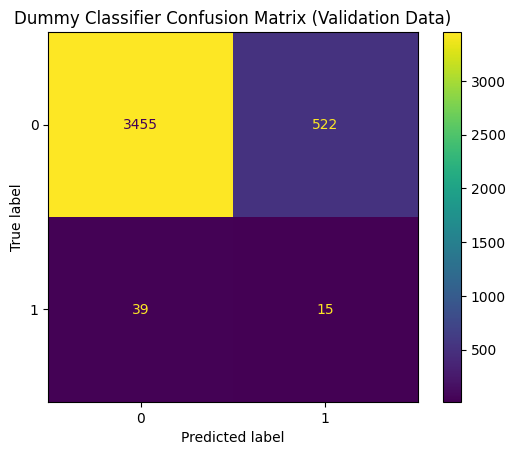

In [726]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Dummy Classifier Confusion Matrix (Validation Data)")
plt.show()

Dari grafik yang diperlihatkan, model dapat memprediksi dengan tepat 15 applicant yang hired sehingga setelah dilakukan sorting data dengan predicted is_hired = 1 HR dapat memprediksi 15 hired karyawan yg benar dari 537 data yang pertama kali diseleksi.

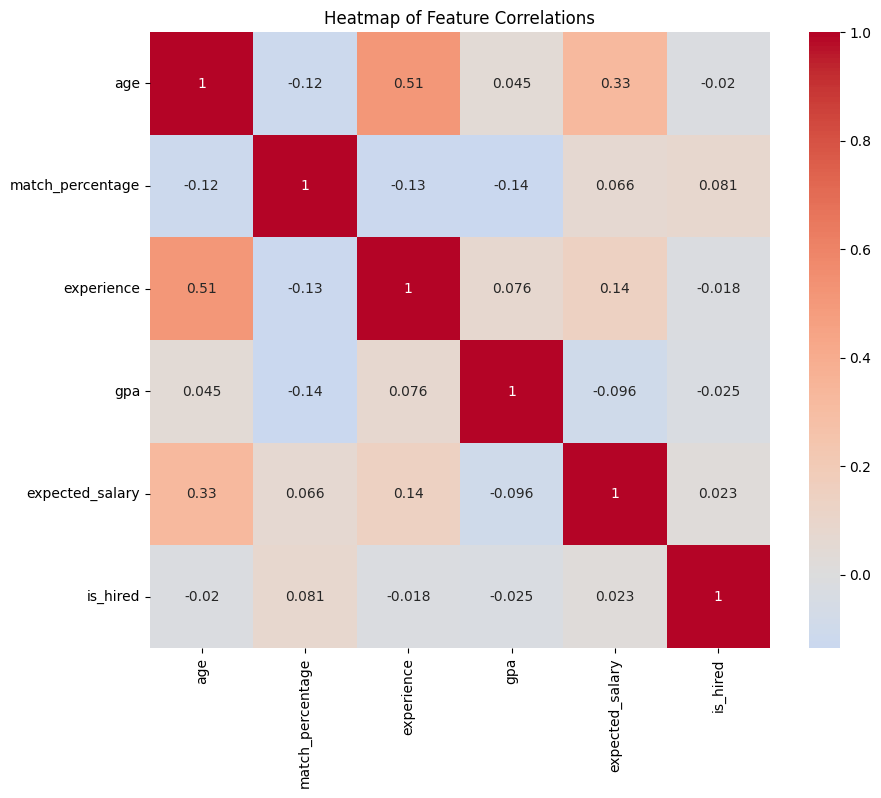

In [729]:
# Hitung korelasi Pearson untuk fitur numerik
correlations = cleaned_data[['age', 'match_percentage', 'experience', 'gpa', 'expected_salary', 'is_hired']].corr()

# Buat heatmap menggunakan seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap of Feature Correlations')
plt.show()